#### Домашнее задание 5
Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('airline-passengers.csv') 
df['sequence_M'] = df.index
df['M'] = df['Month'].str.slice(start=-2).astype(int)
df['Y'] = df['Month'].str.slice(stop=4).astype(int)
df.sort_values(by='sequence_M', ascending=False)
df = df.drop(columns = 'Month');
sc = StandardScaler()
data = sc.fit_transform(df)
data_f = pd.DataFrame(data)
# train, test = train_test_split(data, test_size=0.2, shuffle = False)
# train_data = pd.DataFrame(train)
# val_data = pd.DataFrame(test)

In [4]:
data_f

,0,1,2,3
0,-1.407779,-1.720064,-1.593255,-1.593255
1,-1.357590,-1.696007,-1.303572,-1.593255
2,-1.240483,-1.671950,-1.013890,-1.593255
3,-1.265578,-1.647894,-0.724207,-1.593255
4,-1.332496,-1.623837,-0.434524,-1.593255
...,...,...,...,...
139,2.724417,1.623837,0.434524,1.593255
140,1.904669,1.647894,0.724207,1.593255
141,1.511525,1.671950,1.013890,1.593255
142,0.917627,1.696007,1.303572,1.593255


In [5]:
def train_test_split(data_f, channelIndexes, split, xLen, bias, step, future, plot = 0):
    # channelIndexes - список признаков, по которым будем учить
    # valLen - длина теста 20
    # xLen - длина истории для работы (длина прошлого ) 3  !!! это просто отступ от начала истории!!!
    # bias отступ тестов от тренировок 3
    # step - шаг по данным для построения обучающих примеров 1
    # future - горизонт предсказания
   
    valLen = int(data_f.shape[0]*split) # переводим проценты в длину
    train_split = data_f.shape[0] - valLen - bias
    train_data = data_f.iloc[0 : train_split - 1,channelIndexes]
    val_data = data_f.iloc[train_split+bias:,channelIndexes]
    

    start = xLen + future # сдвиг y на историю и горизнт предсказания, т.е. точка начала таргета на которую мы обучаем модель
    end = start + train_split-1 # точка конца периода таргета на который мы обучаем модель

    xTrain = train_data[train_data.columns].values # признаки временной последовательности - вход для обучения мадели на таргет
    yTrain = data_f.iloc[start:end,0].values # последовательность таргета сдвинутая на историю и горизлнт прогнозирования
    
    sequence_length = int(xLen / step) # количество шагов

    x_end = len(val_data) - xLen - future # отрезаем часть точек от конца тестовой последовательности признаков, 
                                          #т.к. для этого хвоста нет таргета
    label_start = len(train_data) + bias + xLen + future # точка начала таргета последовательности на тесте, 
                                                    #с учетом всех сдвигов которые были сделаны на трейне

    xVal = val_data.iloc[:x_end+1].values # формируем окончательный сет тестовых признаков, с учетом сдвигов таргета
    yVal = data_f.iloc[label_start:,0].values # формируем окончательный сет тестового таргета, с учетом его сдвига на трейне
    
#     print(f'start - {start}, end - {end}, x_end - {x_end}, label_start - {label_start}')
    if plot !=0:
        plt.figure(figsize=(20,5))
        plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
        plt.plot(data_f.index[yTrain.shape[0]+xLen+bias+future:],yVal[:])
        plt.grid('on')
        plt.xlabel('m, месяцы')
        plt.ylabel('Number')
        plt.title('airline-passengers')
        plt.show()
    
    return xTrain, yTrain, xVal, yVal,train_split

In [6]:
# настройка гиперпарамеров
channelIndexes = data_f.columns
valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 1


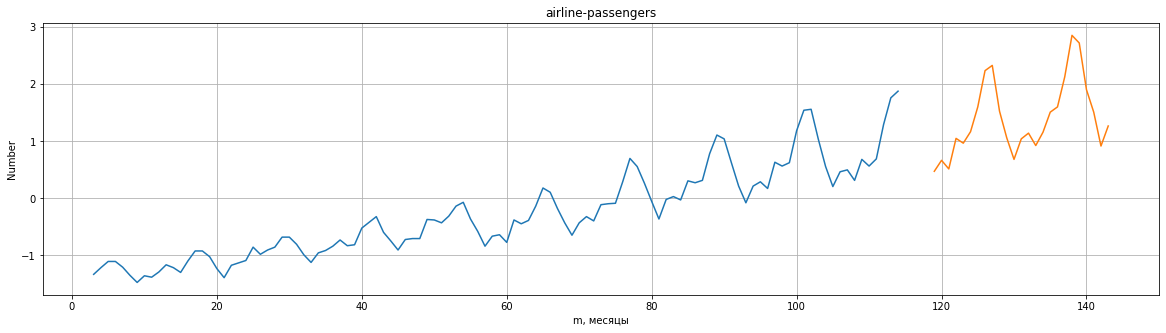

In [7]:
# проверка разделения датасета
xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, future, plot = 1)

In [99]:
def model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size, n_nn=32):
    # делим трайн и тест на последовательности для последующего скармливания lstm
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        xTrain,
        yTrain,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        xVal,
        yVal,
        sequence_length=xLen,
        sampling_rate=1,
        batch_size=batch_size,
    )
    
    # формируем несколько последовательностей входов и выходов, это все подготовка данных к скармиливанию в lstm
    for batch in dataset_train.take(2):
        inputs, targets = batch

#     print("Input shape:", inputs.numpy().shape)
#     print("Target shape:", targets.numpy().shape)
    


    model = Sequential() # объявлям модель
    #добавляем слои, смотрим за размерностью тензоров
    model.add(LSTM(n_nn, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
    model.add(LSTM(n_nn, return_sequences="True"))
    model.add(Conv1D(64, 3, activation="linear"))
    #model.add(Conv1D(64, 1, activation="linear"))
    model.add(Flatten()) # расплетает тензор в одномерный массив
    model.add(Dense(3, activation="linear"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss="mse", optimizer="adam", metrics=['mae'])
    
    
    return model, dataset_train, dataset_val

In [94]:
def fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, epochs, monitor, patience, plot = 0):
    
    # настраиваем инструмент для раннего выхода из обучения по критериям
    callback = EarlyStopping(monitor=monitor, patience=patience)
    
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[callback], verbose = False)
    
    if plot !=0:
        plt.plot(history.history['mae'][1:], 
                 label='Средняя абсолютная ошибка на обучающем наборе')
        plt.plot(history.history['val_mae'][1:], 
                 label='Средняя абсолютная ошибка на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()
        
    predVal = model.predict(dataset_val).flatten()
    corr = check_model(yVal, predVal, ptick = 0.3, plot = 1)
    
    return model, history, corr

In [18]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()

    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

In [92]:
def check_model(yVal, predVal, ptick = 0.3, plot = 0):
    corr = []
    yLen = yVal.shape[0]
    yValF = yVal[:predVal.shape[0]]
    n_tick = int(yVal.shape[0]*ptick)
    for i in range(1,n_tick):
        corr.append(correlate(yValF[:-i], predVal[i:]))
    if plot != 0:
        plt.plot(corr, label='Корреляция')
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.legend()
        plt.show()
    
    crr = corr[0]
    
    if (crr == max(corr)) & (crr > 0.7):
        print(f'Корреляция в первого тика  = {round(crr,2)}. Модель можно применить, так как корреляция убывает на сдвиге')
    else:
        print(f'Корреляция первого тика = {round(crr,2)}. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7')
    return round(crr,2) 

In [10]:
batch_size = 32
epochs = 100
learning_rate = 0.001
monitor = 'val_mae' 
patience = 10

In [11]:
model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size)

Input shape: (32, 3, 4)
Target shape: (32,)


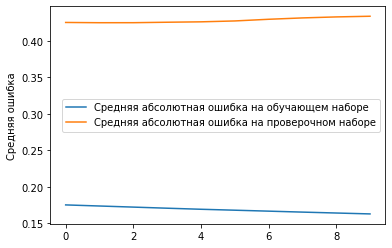

Корреляция первого тика = 0.24. Модель плохая, так как корреляция не убывает на сдвиге и меньше 0.7


In [76]:
epochs = 200
model, history = fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, epochs, monitor, patience, plot = 1)

In [13]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [14]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [15]:
past = xLen
p = past
h=future

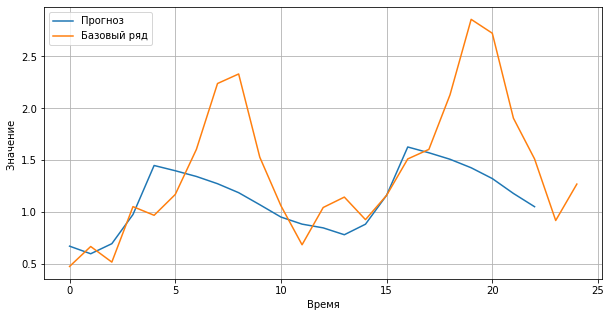

In [16]:
start = 0
# step = 20
h = 0
step = yVal.shape[0]
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[h+start:h+start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

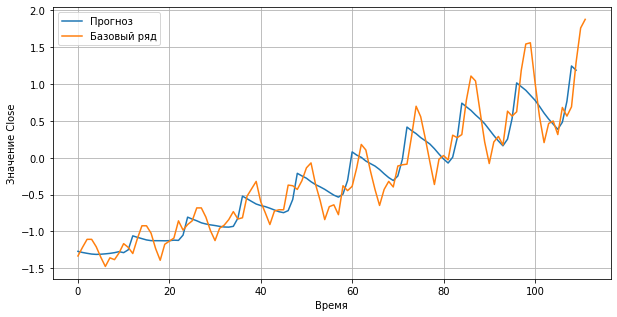

In [17]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[h+start:h+train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

#### Исследование влияния гиперпараметров на lstm для временных рядов

Модель на горизонте 1: 


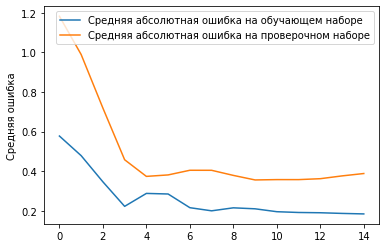

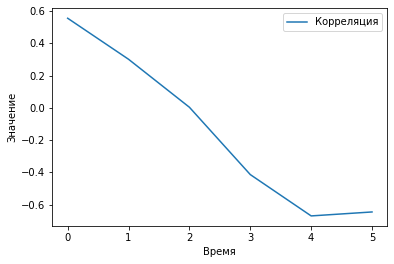

Корреляция первого тика = 0.56. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на горизонте 2: 


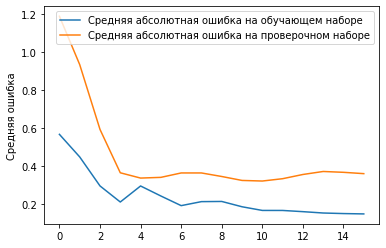

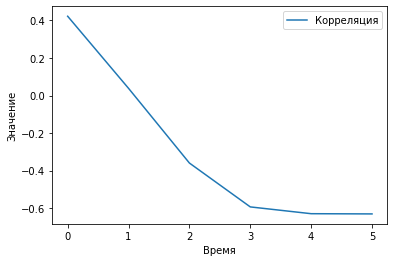

Корреляция первого тика = 0.42. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на горизонте 3: 


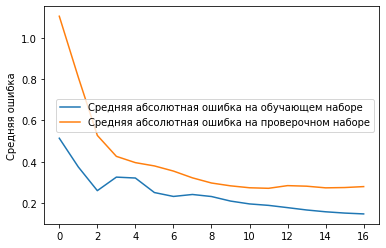

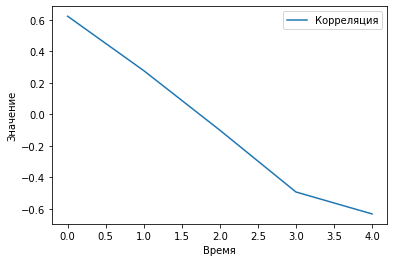

Корреляция первого тика = 0.62. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на горизонте 4: 


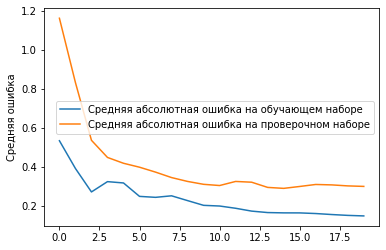

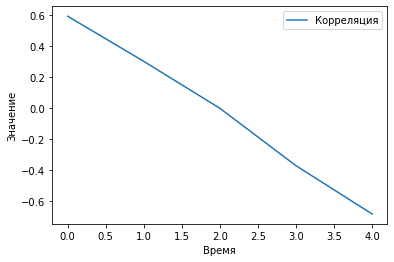

Корреляция первого тика = 0.59. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на горизонте 5: 


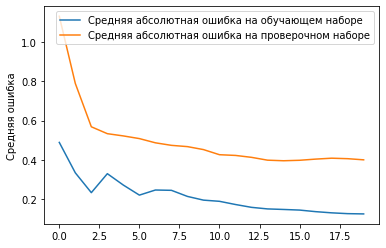

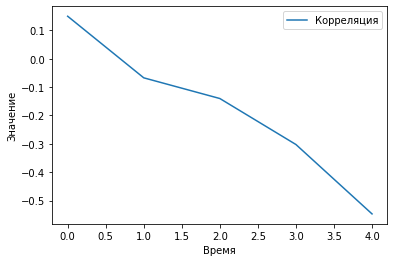

Корреляция первого тика = 0.15. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7


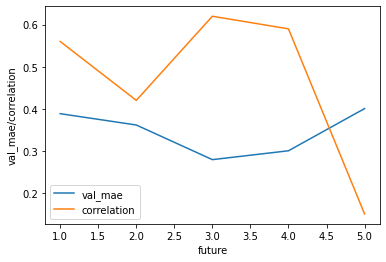

In [100]:
valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 1
batch_size = 32
epochs = 100
monitor = 'val_mae' 
patience = 5
n_nn = 64

future = [1,2,3,4,5]
acc = []
for i in future:
    xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, i, plot = 0)
    model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size,n_nn)
    print(f'Модель на горизонте {i}: ')
    model, history, corr = fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, epochs, monitor, patience,plot = 1)
    acc.append([i, history.history['val_mae'][-1], corr])
acca = np.array(acc)
plt.plot(acca[:,0], acca[:,1], label='val_mae')
plt.plot(acca[:,0], acca[:,2], label='correlation')
plt.xlabel('future')
plt.ylabel('val_mae/correlation')
plt.legend()
plt.show()

**Вывод по величине горизонта:** самая лучша точность и качество моедли на горизонте равным 3 и 4 (повторяется при нескольких запусках)

Модель на batch_size 4: 


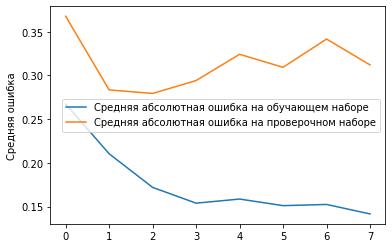

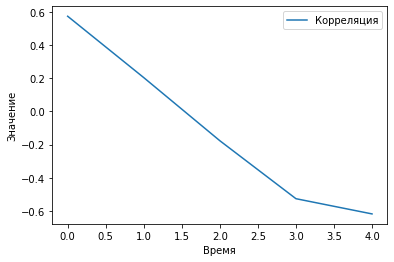

Корреляция первого тика = 0.57. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на batch_size 8: 


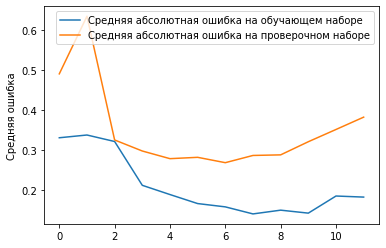

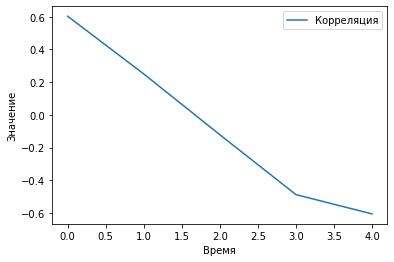

Корреляция первого тика = 0.6. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на batch_size 16: 


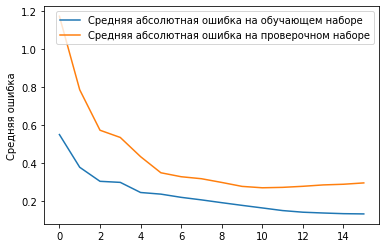

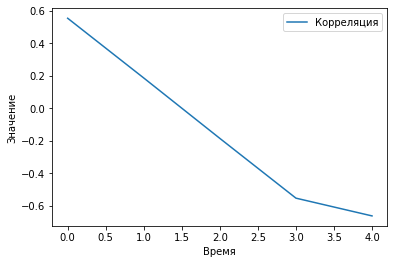

Корреляция первого тика = 0.55. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на batch_size 32: 


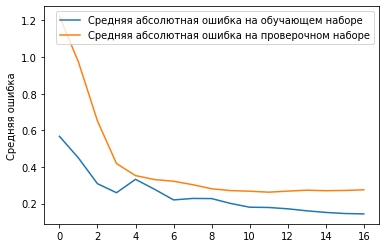

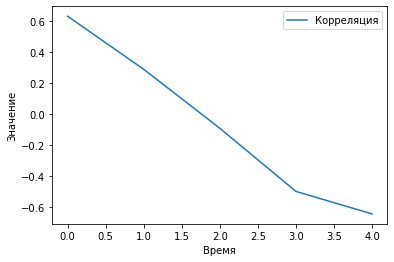

Корреляция первого тика = 0.63. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на batch_size 64: 


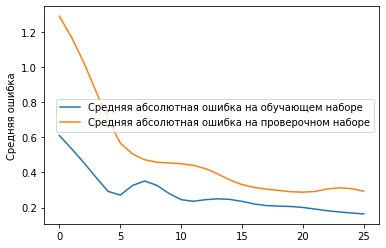

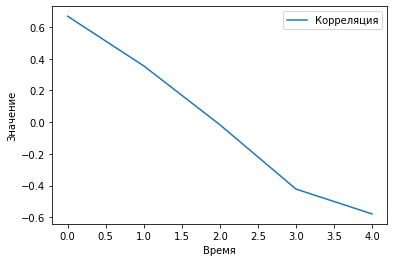

Корреляция первого тика = 0.67. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на batch_size 128: 


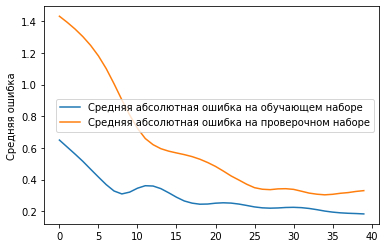

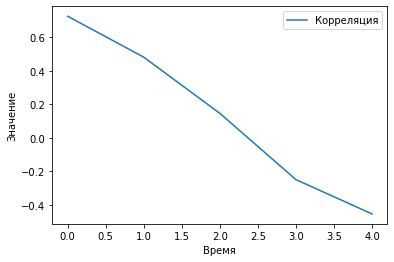

Корреляция в первого тика  = 0.73. Модель можно применить, так как корреляция убывает на сдвиге
Модель на batch_size 256: 


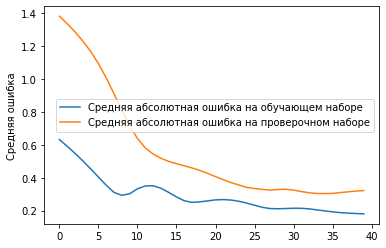

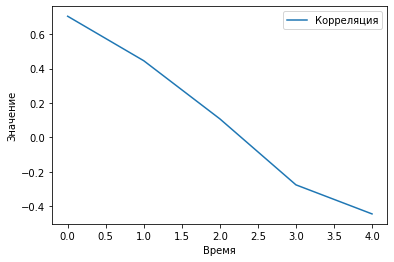

Корреляция в первого тика  = 0.7. Модель можно применить, так как корреляция убывает на сдвиге
Модель на batch_size 512: 


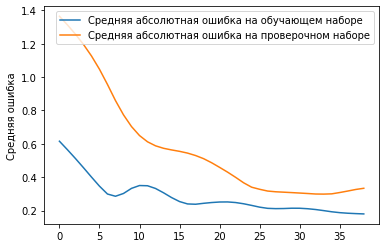

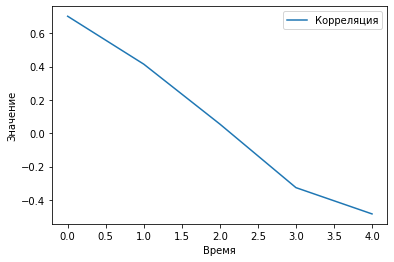

Корреляция в первого тика  = 0.7. Модель можно применить, так как корреляция убывает на сдвиге


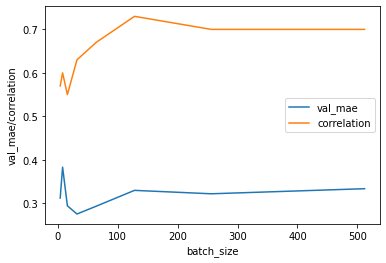

In [105]:
valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 3
batch_size = 32
epochs = 100
monitor = 'val_mae' 
patience = 5
n_nn = 64
batch_size = [4,8,16,32,64,128,256,512]
acc = []
for i in batch_size:
    xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, future, plot = 0)
    model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, i, n_nn)
    print(f'Модель на batch_size {i}: ')
    model, history, corr = fit_lstm(model, dataset_train, dataset_val, yVal, i, epochs, monitor, patience,plot = 1)
    acc.append([i, history.history['val_mae'][-1], corr])
acca = np.array(acc)
plt.plot(acca[:,0], acca[:,1], label='val_mae')
plt.plot(acca[:,0], acca[:,2], label='correlation')
plt.xlabel('batch_size')
plt.ylabel('val_mae/correlation')
plt.legend()
plt.show()

**Вывод по величине batch_size:** самая лучша точность c batch_size равным 256 и 512 (повторяется при нескольких запусках)

Модель на epochs 20: 


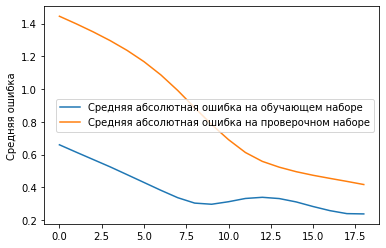

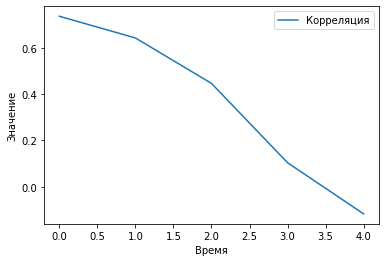

Корреляция в первого тика  = 0.74. Модель можно применить, так как корреляция убывает на сдвиге
Модель на epochs 50: 


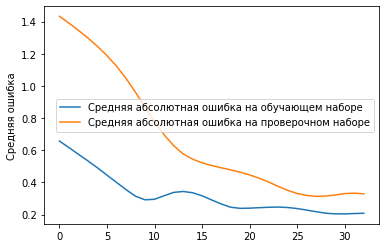

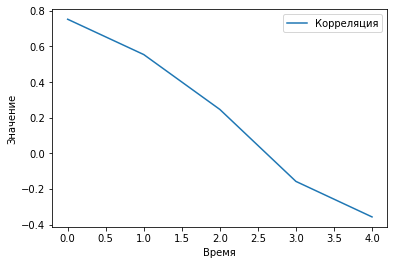

Корреляция в первого тика  = 0.75. Модель можно применить, так как корреляция убывает на сдвиге
Модель на epochs 100: 


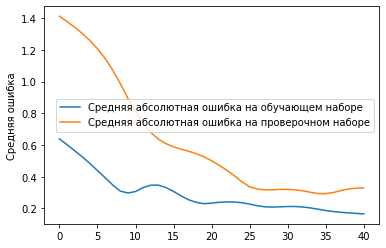

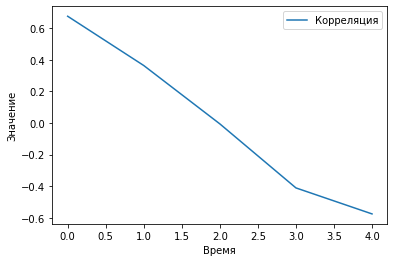

Корреляция первого тика = 0.68. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на epochs 200: 


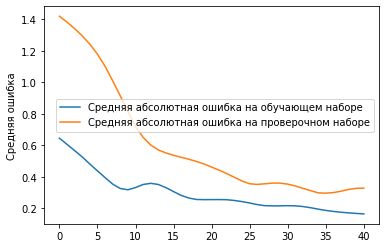

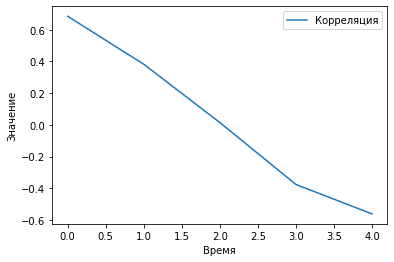

Корреляция первого тика = 0.68. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на epochs 500: 


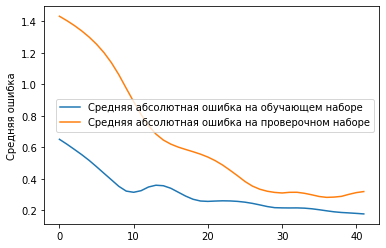

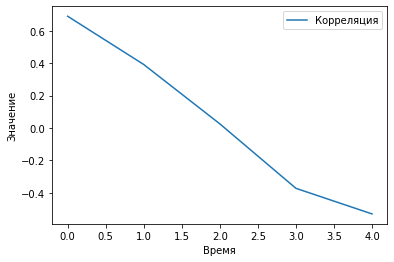

Корреляция первого тика = 0.69. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7


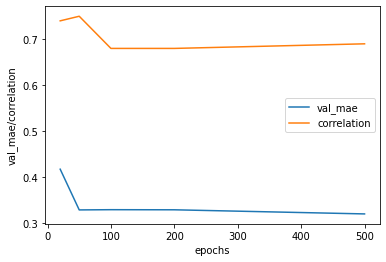

In [113]:
valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 3
batch_size = 512
epochs = 100
monitor = 'val_mae' 
patience = 5
n_nn = 64
epochs = [20, 50, 100, 200,500]
acc = []
for i in epochs:
    xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, future, plot = 0)
    model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size, n_nn)
    print(f'Модель на epochs {i}: ')
    model, history, corr = fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, i, monitor, patience,plot = 1)
    acc.append([i, history.history['val_mae'][-1], corr])
acca = np.array(acc)
plt.plot(acca[:,0], acca[:,1], label='val_mae')
plt.plot(acca[:,0], acca[:,2], label='correlation')
plt.xlabel('epochs')
plt.ylabel('val_mae/correlation')
plt.legend()
plt.show()

**Вывод по величине epochs:** самая лучшая пара корреляция - точность c epochs в лиапазоне от 50 до 200 (повторяется при нескольких запусках)

Модель на patience 2: 


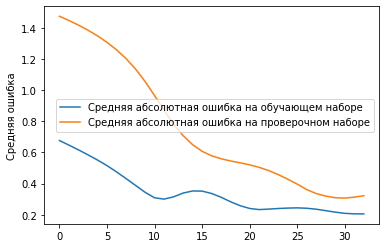

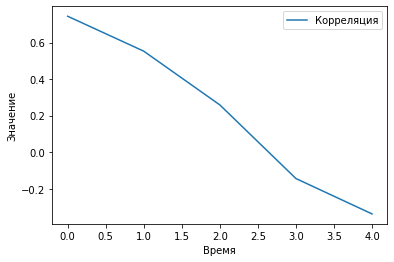

Корреляция в первого тика  = 0.74. Модель можно применить, так как корреляция убывает на сдвиге
Модель на patience 3: 


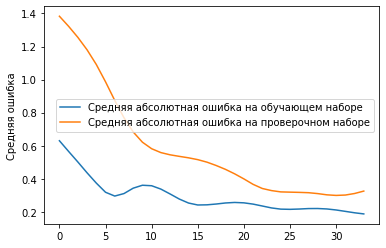

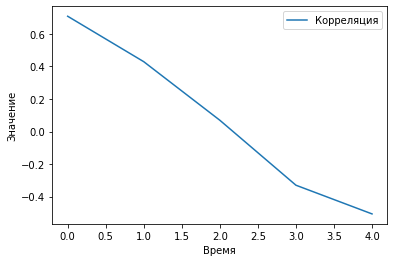

Корреляция в первого тика  = 0.71. Модель можно применить, так как корреляция убывает на сдвиге
Модель на patience 4: 


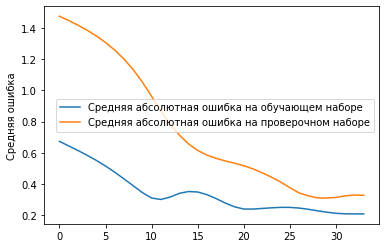

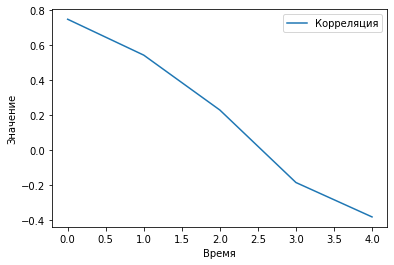

Корреляция в первого тика  = 0.75. Модель можно применить, так как корреляция убывает на сдвиге
Модель на patience 5: 


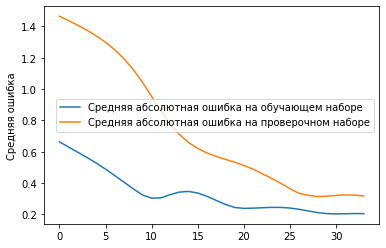

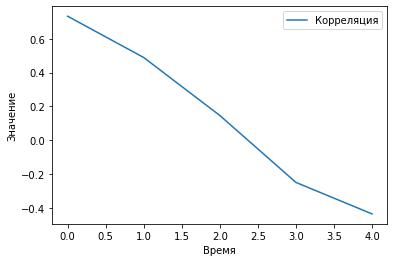

Корреляция в первого тика  = 0.73. Модель можно применить, так как корреляция убывает на сдвиге
Модель на patience 10: 


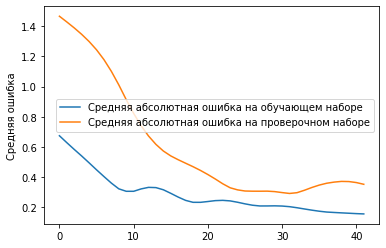

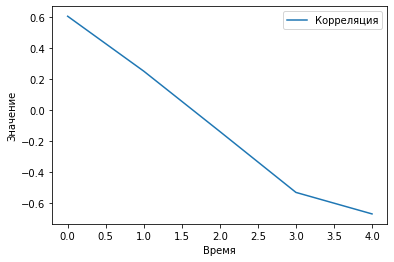

Корреляция первого тика = 0.61. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на patience 15: 


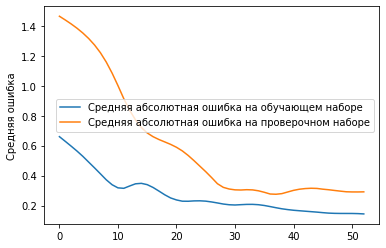

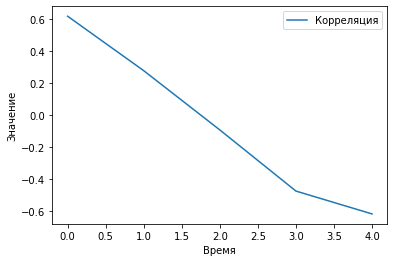

Корреляция первого тика = 0.62. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7


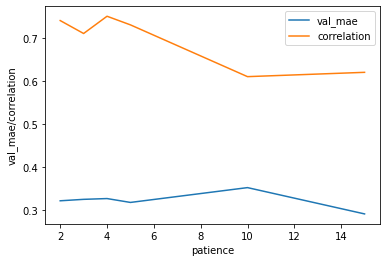

In [115]:
valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 3
batch_size = 512
epochs = 200
monitor = 'val_mae' 
patience = 10
n_nn = 64
patience = [2, 3, 4, 5, 10, 15]
acc = []
for i in patience:
    xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, future, plot = 0)
    model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size, n_nn)
    print(f'Модель на patience {i}: ')
    model, history, corr = fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, epochs, monitor, i,plot = 1)
    acc.append([i, history.history['val_mae'][-1], corr])
acca = np.array(acc)
plt.plot(acca[:,0], acca[:,1], label='val_mae')
plt.plot(acca[:,0], acca[:,2], label='correlation')
plt.xlabel('patience')
plt.ylabel('val_mae/correlation')
plt.legend()
plt.show()

**Вывод по величине patience:** самая лучшая пара корреляция - точность c patience на 4 (повторяется при нескольких запусках)

**Вывод общий:** точность и качество модели удалось повысить благодря подбору таких параметров как горизонт предсказания, batch_size, количество эпох и количество повторяющихся значений без улучшения.
Оптимальные значения для данной реализации:
patience

In [ ]:
future = 3
batch_size = 512
epochs = 200
patience = 4

Модель на цикле 0: 


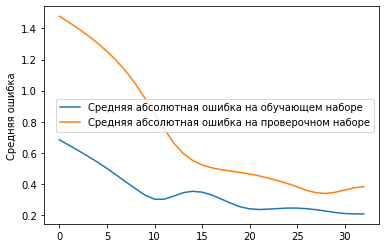

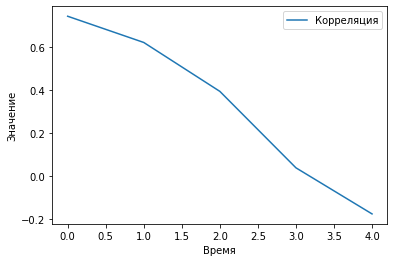

Корреляция в первого тика  = 0.74. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 1: 


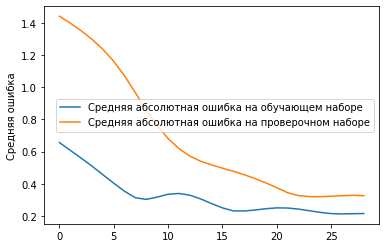

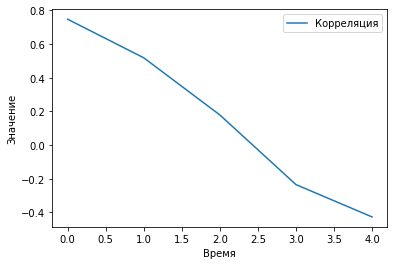

Корреляция в первого тика  = 0.75. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 2: 


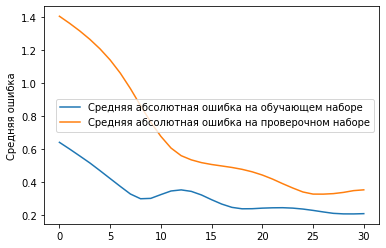

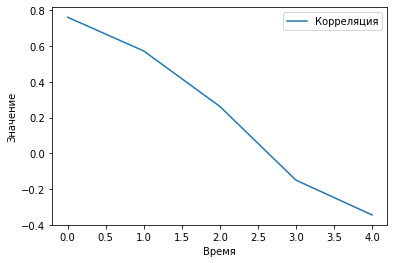

Корреляция в первого тика  = 0.76. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 3: 


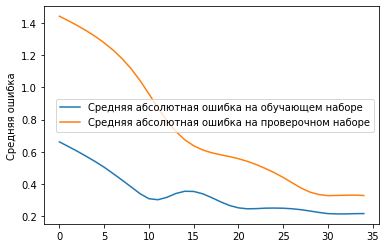

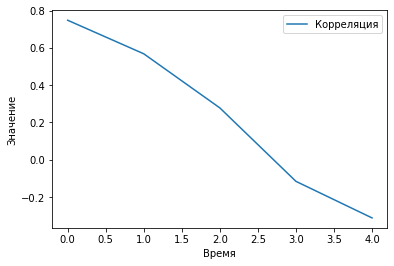

Корреляция в первого тика  = 0.75. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 4: 


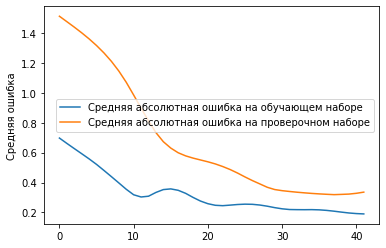

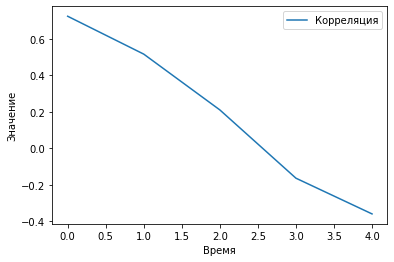

Корреляция в первого тика  = 0.72. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 5: 


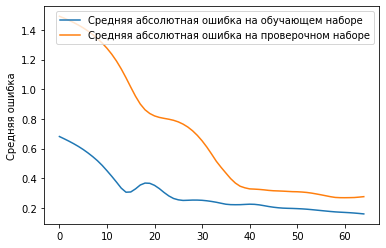

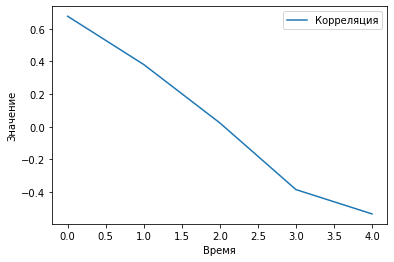

Корреляция первого тика = 0.68. Модель плохая, так как либо корреляция не убывает на сдвиге, либо меньше 0.7
Модель на цикле 6: 


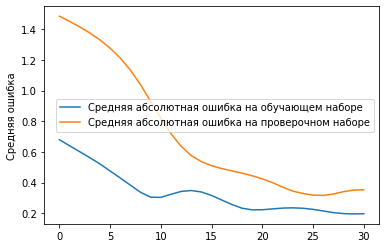

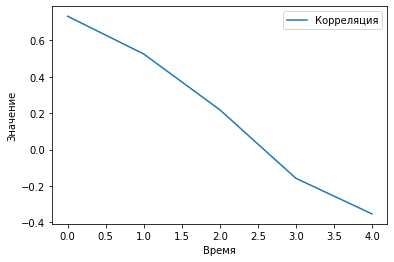

Корреляция в первого тика  = 0.73. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 7: 


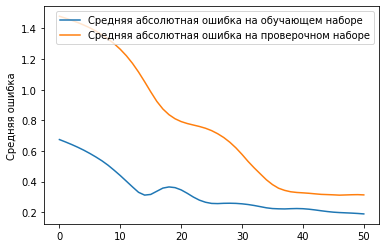

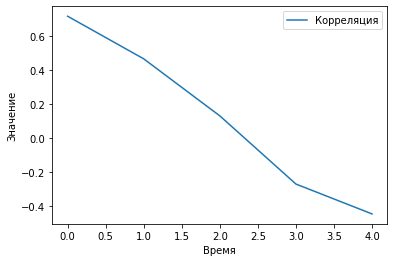

Корреляция в первого тика  = 0.72. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 8: 


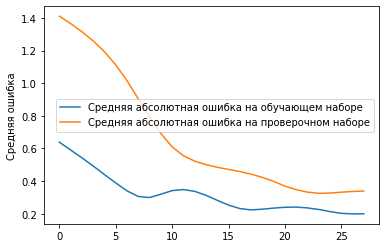

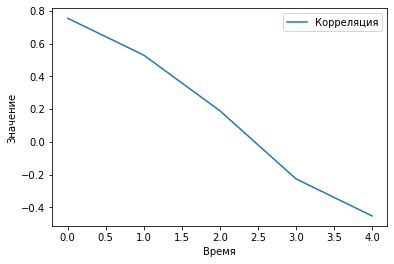

Корреляция в первого тика  = 0.75. Модель можно применить, так как корреляция убывает на сдвиге
Модель на цикле 9: 


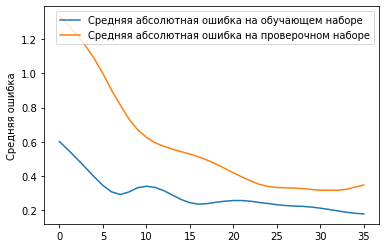

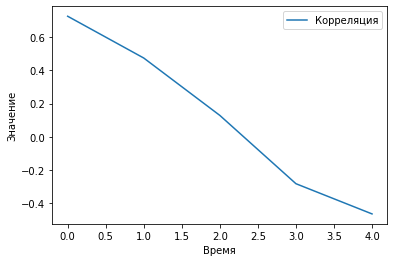

Корреляция в первого тика  = 0.73. Модель можно применить, так как корреляция убывает на сдвиге


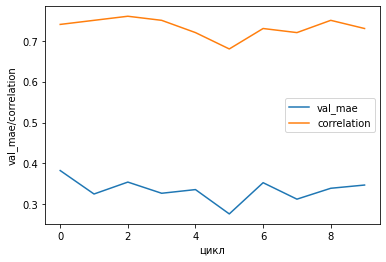

In [116]:
# проверим еще раз на стабильность результата

valLen = 0.2
xLen = 3
bias = 3
step = 1
future = 3
batch_size = 512
epochs = 200
monitor = 'val_mae' 
patience = 4
n_nn = 64

acc = []
for i in range(10):
    xTrain, yTrain, xVal, yVal,train_split = train_test_split(data_f, channelIndexes, valLen, xLen, bias, step, future, plot = 0)
    model, dataset_train, dataset_val = model_lstm_time(xTrain, yTrain, xVal, yVal, xLen, batch_size, n_nn)
    print(f'Модель на цикле {i}: ')
    model, history, corr = fit_lstm(model, dataset_train, dataset_val, yVal, batch_size, epochs, monitor, patience,plot = 1)
    acc.append([i, history.history['val_mae'][-1], corr])
acca = np.array(acc)
plt.plot(acca[:,0], acca[:,1], label='val_mae')
plt.plot(acca[:,0], acca[:,2], label='correlation')
plt.xlabel('цикл')
plt.ylabel('val_mae/correlation')
plt.legend()
plt.show()